In [134]:
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import tensorflow as tf
from keras.models import Sequential, Model, save_model, load_model
from keras.applications import vgg16
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical, plot_model

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

plt.rcParams['font.family'] = 'Malgun Gothic'
warnings.filterwarnings(action='ignore')

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

---
## 데이터 불러오기

In [124]:
PATH='./dataset/'

# train data & label => x_train, y_train"
train_images_path = PATH + "kmnist-train-imgs.npz"
train_labels_path = PATH + "kmnist-train-labels.npz"

# test data & label => x_test, y_test
test_images_path = PATH + "kmnist-test-imgs.npz"
test_labels_path = PATH + "kmnist-test-labels.npz"

In [125]:
# npz파일 load하기
train_images = np.load(train_images_path)['arr_0']
train_labels = np.load(train_labels_path)['arr_0']
test_images = np.load(test_images_path)['arr_0']
test_labels = np.load(test_labels_path)['arr_0']

In [126]:
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

---
## 데이터 살펴보기

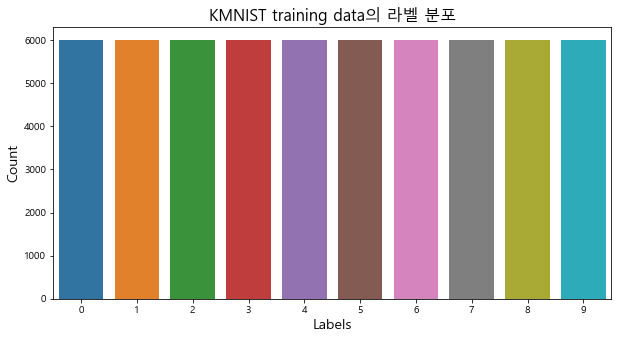

In [127]:
# 라벨값 확인
labels=np.unique(train_labels)
# 라벨값 빈도수 확인
frequency_count = np.bincount(train_labels)

# 시각화 
plt.figure(figsize=(10,5))
sns.barplot(x=labels, y=frequency_count);
plt.title("KMNIST training data의 라벨 분포", fontsize=16)
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

- train data의 각 label에 대한 무작위 샘플을 얻기
- 각 캐릭터(label)의 이미지가 어떻게 생겼는지, 같은 클래스의 샘플 간 변동은 어느 정도인지 알아보기 위함
- 어떻게 정확하게 그룹화할 수 있을까?

In [130]:
random_samples=[]
for i in range(10):
    samples = train_images[np.where(train_labels == i)][:4] # 4개만
    random_samples.append(samples)
    
# list -> array 형변환
random_samples = np.array(random_samples)

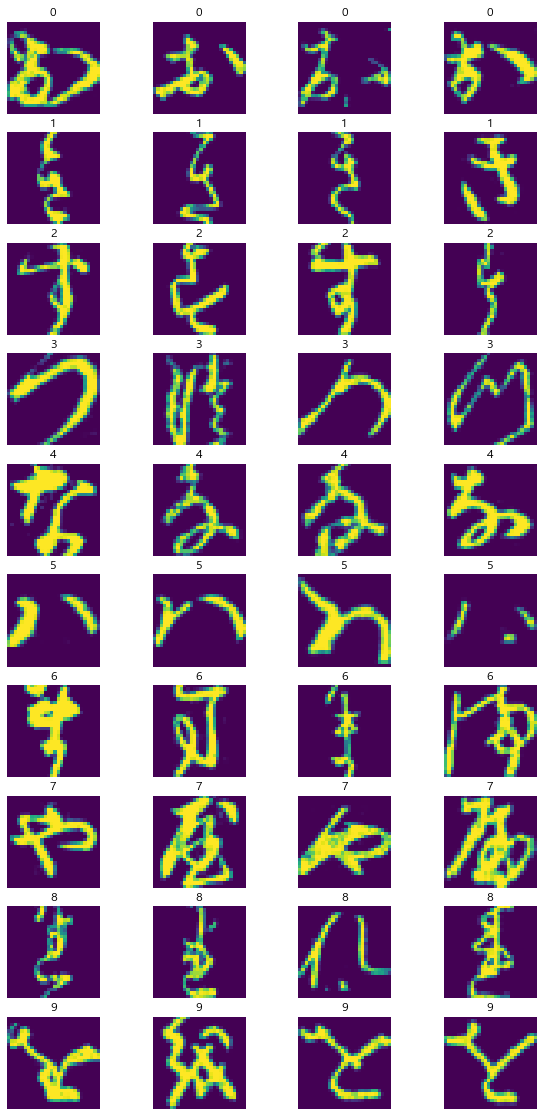

In [131]:
# random_samples 시각화
f, ax = plt.subplots(10,4, figsize=(10,20))
for i, j in enumerate(random_samples):
    for n in range(4):
        ax[i, n].imshow(random_samples[i][n])

        ax[i, n].set_title(str(i))
        ax[i, n].axis('off') # x, y축 눈금 제거
        ax[i, n].set_aspect('equal') # x, y축 비율

---
## t-SNE & UMAP
- 고차원 데이터의 시각화
- t-SNE => 계산 비용이 큼, t-SNE의 sklearn 구현 속도 느림. 단일 코어에서 실행되며 메모리가 사용량이 매우 큼. => 샘플 수를 최대 5000으로 제한(사용자 재량)
- UMAP : 상대적으로 연산속도 빠름, 쉬운 파라미터, 30000 ~ 50000 정도의 더 큰 샘플 사이즈를 사용

- 함께 사용하는 이유
    * t-SNE와 UMAP을 각각 사용했을 때, 대부분의 label들이 다른 cluster들로 완벽하게 분리됨.
    * 하지만 실제 데이터의 경우는 대부분 구분이 명확하지 않음.

In [16]:
labels_dict = dict([(0, u"\u304A"), (1, u"\u304D"), (2, u"\u3059"), (3, u"\u3064"),
                    (4, u"\u306A"), (5, u"\u306F"), (6, u"\u307E"), (7, u"\u3084"),
                    (8, u"\u308C"), (9, u"\u3093")])
print(labels_dict)

{0: 'お', 1: 'き', 2: 'す', 3: 'つ', 4: 'な', 5: 'は', 6: 'ま', 7: 'や', 8: 'れ', 9: 'ん'}


In [132]:
# 데이터를 랜덤으로 가져오는 함수
def get_random_samples(nb_indices):
    random_indices = np.random.choice(nb_indices, size=nb_indices, replace=False)

    random_train_images = train_images[random_indices].astype(np.float32)/255.
    random_train_images = random_train_images.reshape(nb_indices, 28*28)
    random_train_labels = train_labels[random_indices]
    labels = np.unique(random_train_labels)
    return random_indices, random_train_images, random_train_labels, labels

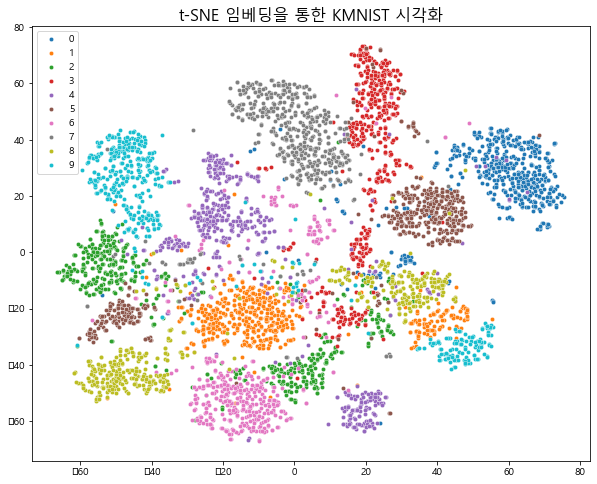

In [133]:
#Get randomly sampled data
nb_indices = 5000
random_indices, random_train_images, random_train_labels, labels = get_random_samples(nb_indices)

# 실제 라벨 이름 가져오기
labels_name = [labels_dict[x] for x in labels]

# t-SNE 객체 생성
tsne = TSNE(n_components=2, random_state=42, perplexity=30)

# t-SNE fit_transform
random_train_2D = tsne.fit_transform(random_train_images)

# 시각화
fig = plt.figure(figsize=(10, 8))

for i, label in zip(labels, labels_name):
    sns.scatterplot(random_train_2D[random_train_labels == i, 0], 
                random_train_2D[random_train_labels == i, 1], 
                label=i, s=18)

plt.title("t-SNE 임베딩을 통한 KMNIST 시각화", fontsize=16)
plt.legend()
plt.show()

In [21]:
# # Let's try UMAP now.
# nb_indices = 10000
# random_indices, random_train_images, random_train_labels, labels = get_random_samples(nb_indices)

# embedding = umap.UMAP(n_components=2, metric='correlation', min_dist=0.8)
# random_train_2D = embedding.fit_transform(random_train_images)

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111) #projection='3d')

# for i, label in zip(labels, labels):
#     sns.scatterplot(random_train_2D[random_train_labels == i, 0], 
#                 random_train_2D[random_train_labels == i, 1], 
#                 label=label, s=15)
# plt.title("Visualiza KMNIST embeddings using UMAP ", fontsize=16)
# plt.legend()
# plt.show()

---
# *Dense*

In [22]:
x_train_Dense=train_images.reshape(-1, 28*28)/255.0
x_test_Dense=test_images.reshape(-1, 28*28)/255.0

In [46]:
x_train_Dense.shape, type(x_train_Dense), x_test_Dense.shape, type(x_test_Dense)

((60000, 784), numpy.ndarray, (10000, 784), numpy.ndarray)

In [47]:
# OHE를 하지 않았을 때 sparse_categorical_crossentropy
y_train=train_labels
y_test=test_labels

# complie할 때 loss='categorical_crossentropy'를 사용하고 싶다면, convert class vectors to binary class matrices
# y_train = to_categorical(train_labels, num_classes)
# y_test = to_categorical(test_labels, num_classes)

In [48]:
y_train.shape, type(y_train), y_test.shape, type(y_test)

((60000,), numpy.ndarray, (10000,), numpy.ndarray)

---
# *Conv2D*

In [65]:
x_train = train_images/255.0
x_test = test_images/255.0

In [60]:
# 모델 구성
model = Sequential()

model.add(Conv2D(32, kernel_size=(3), # 자동으로 (3,3)
                 activation='relu',
                 input_shape=(28, 28, 1))) # (28, 28), 1은 흑백
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # 축소
model.add(Dropout(0.25)) # 과적합 방지
model.add(Flatten()) # 펼침
model.add(Dense(128, activation='relu')) # 펼치고 Dense하면 정확도 상승
model.add(Dropout(0.5)) # 과적합 방지
model.add(Dense(10, activation='softmax')) # 출력층

In [61]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1179776   
                                                     

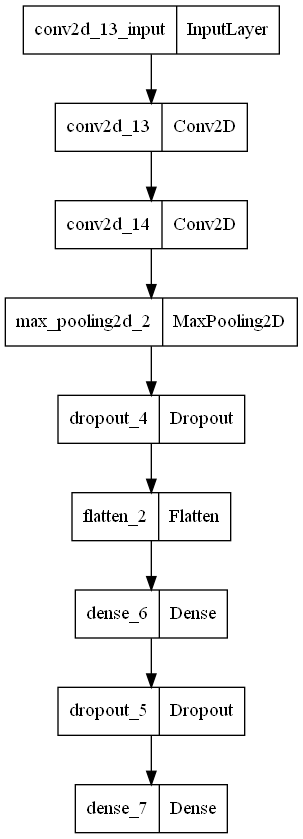

In [62]:
plot_model(model)

In [66]:
# 모델 생성
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [67]:
# 모델 학습
Conv2D_result = model.fit(x_train, y_train, 
                          batch_size=128, 
                          epochs=12, 
                          validation_data=(x_test, y_test))

Epoch 1/12
469/469 [==============================] - 55s 117ms/step - loss: 0.4360 - accuracy: 0.8644 - val_loss: 0.3701 - val_accuracy: 0.8900
Epoch 2/12
469/469 [==============================] - 58s 123ms/step - loss: 0.1950 - accuracy: 0.9404 - val_loss: 0.2780 - val_accuracy: 0.9214
Epoch 3/12
469/469 [==============================] - 59s 126ms/step - loss: 0.1419 - accuracy: 0.9558 - val_loss: 0.2471 - val_accuracy: 0.9325
Epoch 4/12
469/469 [==============================] - 60s 127ms/step - loss: 0.1163 - accuracy: 0.9638 - val_loss: 0.2212 - val_accuracy: 0.9383
Epoch 5/12
469/469 [==============================] - 62s 133ms/step - loss: 0.0953 - accuracy: 0.9692 - val_loss: 0.2353 - val_accuracy: 0.9387
Epoch 6/12
469/469 [==============================] - 63s 133ms/step - loss: 0.0852 - accuracy: 0.9723 - val_loss: 0.2171 - val_accuracy: 0.9437
Epoch 7/12
469/469 [==============================] - 62s 131ms/step - loss: 0.0731 - accuracy: 0.9761 - val_loss: 0.2039 - val_ac

In [70]:
# 모델 평가
model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.2343 - accuracy: 0.9476


[0.23429833352565765, 0.9476000070571899]

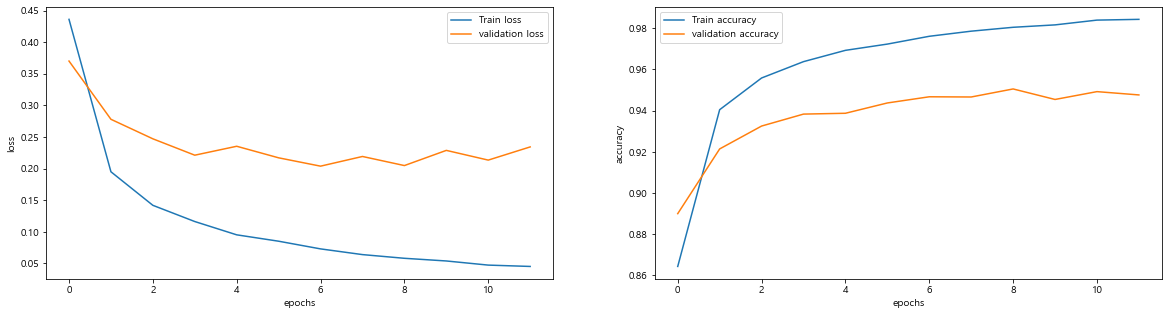

In [123]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
# loss 비교
plt.plot(Conv2D_result.epoch, Conv2D_result.history['loss'],label='Train loss')
plt.plot(Conv2D_result.epoch, Conv2D_result.history['val_loss'],label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(122)
# accuracy 비교
plt.plot(Conv2D_result.epoch, Conv2D_result.history['accuracy'],label='Train accuracy')
plt.plot(Conv2D_result.epoch, Conv2D_result.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()